# Import Libraries

In [49]:
from IPython.display import display

import pandas as pd
import numpy as np

from pathlib import Path
from time import sleep
import requests
from tqdm.notebook import tqdm

from collections import Counter
import json
from wordcloud import WordCloud

from utills import get_prop_info, plot_hist


In [50]:
import matplotlib.pyplot as plt
# % matplotlib inline


# Initialize Variables

In [51]:
prop_entity_api = 'https://www.wikidata.org/w/api.php?' \
    'action=wbgetclaims' \
    '&entity={}' \
    '&property={}' \
    '&format=json' \
    '&formatversion=2'

entity_labels_ar = 'https://www.wikidata.org/w/api.php?' \
    'action=wbgetentities' \
    '&format=json' \
    '&ids={}' \
    '&languages=ar|en' \
    '&props=labels' \
    '&formatversion=2'

USER_AGENT = {
    'User-Agent': 'A bot for get entities in Arabic. (guszarzmo@student.gu.se)'
}  # noqa:


In [52]:
prop_stats_dir = '../../outputs/prop_stats/wikibase-item_quantity_time/'
prop_stats_path = f'{prop_stats_dir}entities.parquet'
entities_info_path = f'{prop_stats_dir}entities_info.json'
conllu_dir = '../../outputs/conllu/wikibase-item_quantity_time/'
conllu_path = f'{conllu_dir}udp_en.conllu'


# Load Wikidata Properties Data

In [53]:
# Read properties labels from Conll-U, return them in a dictionary keyed by property ID
prop_dict = get_prop_info(conllu_path)  
get_prop_label = lambda idx: prop_dict[idx]  # return label using ID  # noqa: E731


In [54]:
prop_stats_df = pd.read_parquet(prop_stats_path)  # Load Wikidata Property
prop_stats_df['prop_label'] = prop_stats_df['property_id'].apply(
    get_prop_label)  # add property label column


In [55]:
display(prop_stats_df)


,property_id,entity,prop_label
0,P6,"[Q17, Q20, Q22, Q25, Q27, Q28, Q29, Q30, Q31, ...",head of government
1,P16,"[Q1243, Q1559, Q1595, Q2108, Q2224, Q2227, Q29...",transport network
2,P17,"[Q17, Q20, Q21, Q22, Q25, Q26, Q27, Q28, Q29, ...",country
3,P19,"[Q5, Q23, Q24, Q42, Q80, Q1868, Q2001, Q76, Q9...",place of birth
4,P20,"[Q5, Q23, Q42, Q1868, Q2001, Q91, Q254, Q255, ...",place of death
...,...,...,...
1957,P10527,"[Q254, Q255, Q307, Q392, Q448, Q449, Q493, Q53...",documentation files at
1958,P10612,"[Q180856, Q3307008, Q58483088, Q108525916, Q10...",choreography for
1959,P10663,"[Q24, Q302, Q907, Q931, Q2142, Q2281, Q4252, Q...",applies to work
1960,P10741,"[Q400, Q11637, Q11639, Q16849, Q31899, Q34424,...",dance style


Filter Properties that has no entity

In [56]:
no_entity = prop_stats_df['entity'].apply(lambda e: len(e)) == 0
no_entity_df = prop_stats_df[no_entity]

In [57]:
display(no_entity_df)

,property_id,entity,prop_label
1290,P3775,[],disrupting agent for
1539,P5194,[],officialized by
1571,P5427,[],position of accent nucleus
1572,P5428,[],position of devoiced vowel
1667,P5923,[],creates lexeme type
1689,P6084,[],location of sense usage


In [58]:
prop_stats_df = prop_stats_df[~no_entity]

# Get the Entities' Labels in Arabic 

Transform each element of a the entity list to a row, replicating index, `property_id` and `prop_label` values

In [59]:
prop_entity_df = prop_stats_df.explode('entity')

In [60]:
display(prop_entity_df)

,property_id,entity,prop_label
0,P6,Q17,head of government
0,P6,Q20,head of government
0,P6,Q22,head of government
0,P6,Q25,head of government
0,P6,Q27,head of government
...,...,...,...
1961,P11105,Q117459541,annotator
1961,P11105,Q117459681,annotator
1961,P11105,Q117463494,annotator
1961,P11105,Q117467749,annotator


Get the number of Entities we have.

In [61]:
entities = prop_entity_df['entity'].unique()
print(f'There are {len(entities)} entities')


There are 2243973 entities


In [62]:
# Load entity data if not exist Get the labels for both English and Arabic languages
if Path(entities_info_path).is_file():
    with open(entities_info_path, "r") as f:
        entities_info = json.load(f)
else:

    entities_chunks = np.array_split(entities, len(entities) // 49)
    entities_info = {}
    pbar = tqdm(total=len(entities_chunks))
    for i, entities_chunk in enumerate(entities_chunks):
        entities_str = '|'.join(entities_chunk)
        retry = True
        retries_num = 0
        failed_chunks = []
        while retry:
            try:
                response = requests.get(entity_labels_ar.format(entities_str),
                                        headers=USER_AGENT)
                if response.status_code == 200:
                    results = response.json()
                    if results.get('success', 0) == 1:
                        ents_dict = results['entities']
                        for ent_id, ent_dict in ents_dict.items():
                            labels_dict = ent_dict.get('labels', {})
                            if 'ar' in labels_dict and 'en' in labels_dict:
                                label_ar = labels_dict['ar']['value']
                                label_en = labels_dict['en']['value']
                            else:
                                label_ar = None
                                label_en = None
                            entities_info[ent_id] = {
                                'ar': label_ar,
                                'en': label_en
                            }
                        retry = False
                        retries_num = 0
                        pbar.update(1)
                        sleep(1)
                    else:
                        retries_num += 1
                        pbar.set_description(
                            f'API Call retuns No Sucess in chunk: {i}')
                        print(f'+ API Call retuns No Sucess in chunk: {i}')
                        sleep(120)
                else:
                    retries_num += 1
                    status = response.status_code
                    pbar.set_description(
                        f'API Call status is {status} in chunck: {i}')
                    print(f'- API Call status is {status} in chunck: {i}')
                    print(f'  {response.content}')
                    sleep(120)
            except ConnectionError:
                retries_num += 1
                pbar.set_description(f'Exception in chunck: {i}')
                print(f'(* Exception in chunck: {i}')
                with open(entities_info_path, "w") as f:
                    json.dump(entities_info, f)
                sleep(180)

                if retries_num >= 3:
                    retry = False
                    retries_num = 0
                    failed_chunks.append(i)

    with open(entities_info_path, "w") as f:
        json.dump(entities_info, f, indent=2)


In [63]:
entity_isar = lambda e: bool(entities_info[e]['ar'])  # noqa: E731
entity_label = lambda e: entities_info[e]['en']  # noqa: E731

In [64]:
# Add two columns, one fir entity labels and the other shows if the entity has an Arabic Labels or not
prop_entity_df['ent_label'] = prop_entity_df['entity'].apply(entity_label)
prop_entity_df['isar'] = prop_entity_df['entity'].apply(entity_isar)

In [65]:
display(prop_entity_df)

,property_id,entity,prop_label,ent_label,isar
0,P6,Q17,head of government,Japan,True
0,P6,Q20,head of government,Norway,True
0,P6,Q22,head of government,Scotland,True
0,P6,Q25,head of government,Wales,True
0,P6,Q27,head of government,Republic of Ireland,True
...,...,...,...,...,...
1961,P11105,Q117459541,annotator,al-Muntaẓam fī tārīkh al-umam wa-al-mulūk (Dar...,True
1961,P11105,Q117459681,annotator,"Al-Mulḥaq Bi-Dhayl A-Rūdhrāwarī (Dar Shrous, 2...",True
1961,P11105,Q117463494,annotator,Masalik Al-Mamalik (Al-Hay’ah al-ʻĀmmah li Quṣ...,True
1961,P11105,Q117467749,annotator,None,False


In [66]:
entities_count = prop_entity_df[['entity',
                                 'isar']].set_index('entity').value_counts()


In [67]:
display(entities_count)


isar 
False    3240087
True     1617882
dtype: int64

In [68]:
entities_ar_count = entities_count[True]
entities_ar_percent = entities_ar_count / entities_count.sum()
print(f'{1 - entities_ar_percent:.2%} of the data will be removed.')


66.70% of the data will be removed.


Filter entitis that have no Arabic label

In [69]:
prop_entity_ar_df = prop_entity_df[prop_entity_df['isar']]
display(prop_entity_ar_df)

,property_id,entity,prop_label,ent_label,isar
0,P6,Q17,head of government,Japan,True
0,P6,Q20,head of government,Norway,True
0,P6,Q22,head of government,Scotland,True
0,P6,Q25,head of government,Wales,True
0,P6,Q27,head of government,Republic of Ireland,True
...,...,...,...,...,...
1961,P11105,Q117382942,annotator,Nishwā‎r Al-Muḥā‎ḍarah Wa-Akhbā‎r Al-Mudhā‎kar...,True
1961,P11105,Q117383058,annotator,Nishwā‎r Al-Muḥā‎ḍarah Wa-Akhbā‎r Al-Mudhā‎kar...,True
1961,P11105,Q117459541,annotator,al-Muntaẓam fī tārīkh al-umam wa-al-mulūk (Dar...,True
1961,P11105,Q117459681,annotator,"Al-Mulḥaq Bi-Dhayl A-Rūdhrāwarī (Dar Shrous, 2...",True


Count how many Arabic labels we have

In [70]:
entities_ar = prop_entity_ar_df['entity'].unique()
print(f'There are {len(entities_ar)} entities with Arabic Labels')
print(f'Percentage of Arabic Entitirs: {len(entities_ar) / len(entities) :.2%}')

There are 416276 entities with Arabic Labels
Percentage of Arabic Entitirs: 18.55%


# Stats

## Entities Distribution

In [71]:
# Count Entity
entities_ar_counter = Counter(prop_entity_ar_df['entity']).most_common()
entities_ar_count = np.array([count for _, count in entities_ar_counter])

print(f'Number of unique entities: {len(entities_ar_count)}')
print(f'Min count: {entities_ar_count.min()}')
print(f'Max count: {entities_ar_count.max()}')
print(f'Average Count: {entities_ar_count.mean().round(2)}')
print(f'Median Count: {np.median(entities_ar_count).round(2)}')
print(f'Labels that are repeated {np.percentile(entities_ar_count, 25)} time represents 25% of the labels.')
print(f'Labels that are repeated less than or equal to {np.percentile(entities_ar_count, 75)} times represents 75% of the labels.')
print(f'Labels that are repeated less than or equal to {np.percentile(entities_ar_count, 90)} times represents 90% of the labels.')


Number of unique entities: 416276
Min count: 1
Max count: 152
Average Count: 3.89
Median Count: 2.0
Labels that are repeated 1.0 time represents 25% of the labels.
Labels that are repeated less than or equal to 4.0 times represents 75% of the labels.
Labels that are repeated less than or equal to 9.0 times represents 90% of the labels.


## Entities per Property Distribution

In [72]:
entities_count = prop_entity_ar_df.groupby('property_id', as_index=False).agg(
    {'entity': list})
entities_count['entity_count'] = entities_count['entity'].apply(len)

display(entities_count)

,property_id,entity,entity_count
0,P1000,"[Q1189, Q1659, Q1665, Q1668, Q1679, Q1739, Q17...",195
1,P1001,"[Q28, Q23, Q2001, Q40, Q45, Q91, Q95, Q96, Q14...",3156
2,P1002,"[Q31170, Q61418, Q127110, Q172672, Q173384, Q2...",73
3,P101,"[Q5, Q42, Q80, Q1868, Q76, Q142, Q157, Q180, Q...",3536
4,P1011,"[Q20, Q29, Q30, Q32, Q2013, Q34, Q39, Q105, Q1...",369
...,...,...,...
1931,P9758,"[Q257, Q1111, Q2878, Q4130, Q5997, Q6158, Q113...",626
1932,P98,"[Q17, Q20, Q27, Q28, Q29, Q30, Q31, Q32, Q1, Q...",4804
1933,P991,"[Q4226, Q8464, Q8469, Q8754, Q8758, Q8883, Q24...",1294
1934,P9929,"[Q262, Q398, Q612, Q657, Q805, Q817, Q846, Q85...",535


In [73]:
entities_count_filtered = entities_count[entities_count['entity_count'] >= 5]

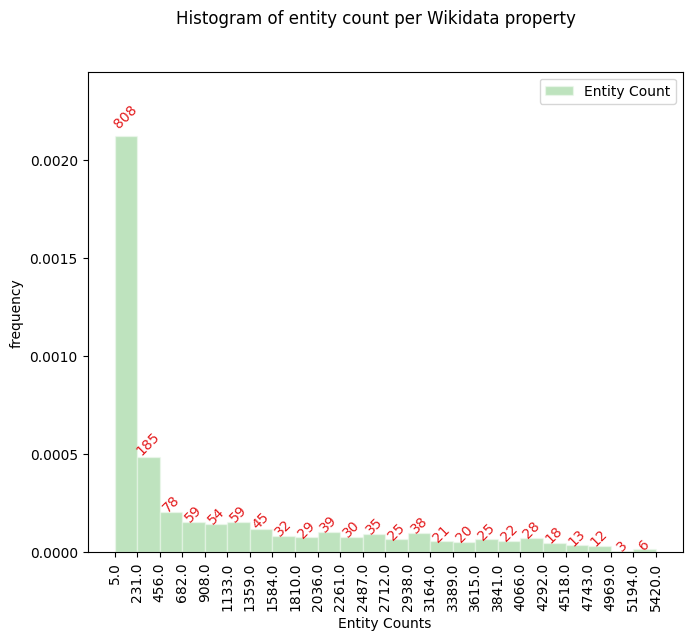

In [74]:
title = 'Histogram of entity count per Wikidata property'
label_x = 'Entity Counts'
label_y = 'frequency'
label_hist = ["Entity Count"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

bins = np.histogram_bin_edges(entities_count_filtered['entity_count'],
                              bins='auto').round()
_ = plot_hist([entities_count_filtered['entity_count'].to_numpy()],
              fig_data=fig_data,
              bins=[bins],
              count=True)


# Get relevent properties

## Choice ONE (min number of entity per property is five)

Relevent properties are those who have entities from 5 upto 682

In [75]:
relevent_props_df = entities_count_filtered.copy()[
    entities_count_filtered['entity_count'] < bins[3]]
relevent_props_df['prop_label'] = relevent_props_df['property_id'].apply(
    get_prop_label)
display(relevent_props_df)

,property_id,entity,entity_count,prop_label
0,P1000,"[Q1189, Q1659, Q1665, Q1668, Q1679, Q1739, Q17...",195,record held
2,P1002,"[Q31170, Q61418, Q127110, Q172672, Q173384, Q2...",73,engine configuration
4,P1011,"[Q20, Q29, Q30, Q32, Q2013, Q34, Q39, Q105, Q1...",369,excluding
7,P1016,"[Q3030, Q11558, Q11560, Q107517, Q140489, Q149...",10,asteroid taxonomy
8,P1018,"[Q143, Q150, Q188, Q256, Q294, Q397, Q652, Q80...",144,language regulatory body
...,...,...,...,...
1922,P9600,"[Q1325, Q11641, Q18227, Q25871, Q29573, Q32338...",265,oral history at
1923,P967,"[Q71926, Q156013, Q216183, Q374368, Q514888, Q...",45,guest of honor
1926,P970,"[Q43054, Q147298, Q505544, Q748049, Q864951]",5,neurological function
1931,P9758,"[Q257, Q1111, Q2878, Q4130, Q5997, Q6158, Q113...",626,symbol represents


### Entity Distribution

In [76]:
entities_ar_counter = Counter(
    relevent_props_df.explode('entity')['entity']).most_common()
entities_ar_count = np.array([count for _, count in entities_ar_counter])
print(f'Number of unique entities: {len(entities_ar_count)}')
print(f'Min count: {entities_ar_count.min()}')
print(f'Max count: {entities_ar_count.max()}')
print(f'Average Count: {entities_ar_count.mean().round(2)}')
print(f'Median Count: {np.median(entities_ar_count).round(2)}')
print(f'Labels that are repeated {np.percentile(entities_ar_count, 25)} time represent 25% of labels')
print(f'Labels that are repeated less than or equal to {np.percentile(entities_ar_count, 75)} times represent 75% of labels')
print(f'Labels that are repeated less than or equal to {np.percentile(entities_ar_count, 90)} times represent 90% of labels')


Number of unique entities: 91179
Min count: 1
Max count: 45
Average Count: 1.72
Median Count: 1.0
Labels that are repeated 1.0 time represent 25% of labels
Labels that are repeated less than or equal to 2.0 times represent 75% of labels
Labels that are repeated less than or equal to 3.0 times represent 90% of labels


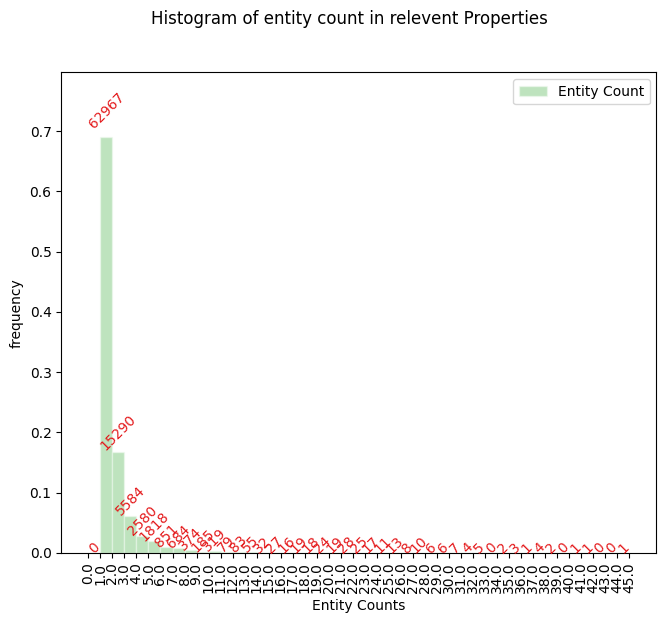

In [77]:
title = 'Histogram of entity count in relevent Properties'
label_x = 'Entity Counts'
label_y = 'frequency'
label_hist = ["Entity Count"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

_ = plot_hist([entities_ar_count],
              fig_data=fig_data,
              bins=[list(range(entities_ar_count.max() + 1))],
              count=True)


### Entities per Property Distribution

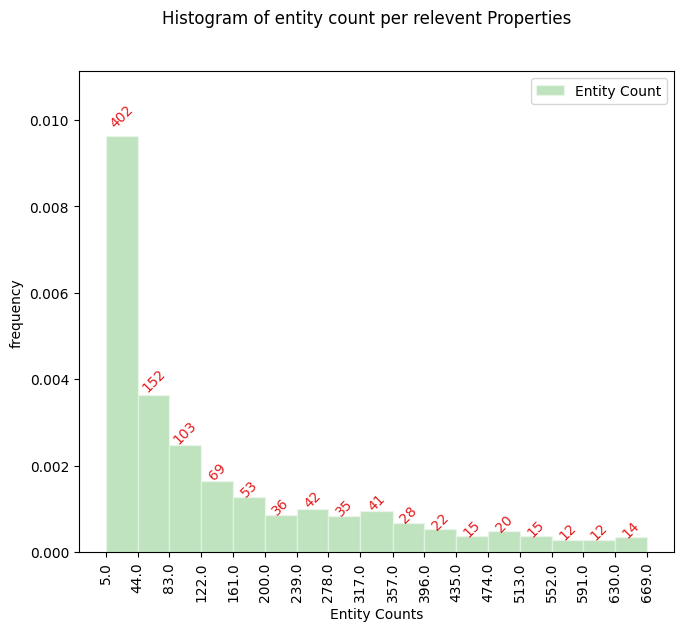

In [78]:
title = 'Histogram of entity count per relevent Properties'
label_x = 'Entity Counts'
label_y = 'frequency'
label_hist = ["Entity Count"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

bins = np.histogram_bin_edges(relevent_props_df['entity_count'],
                              bins='auto').round()
_ = plot_hist([relevent_props_df['entity_count']],
              fig_data=fig_data,
              bins=[bins],
              count=True)


In [79]:
relevent_props_df[relevent_props_df['entity_count'] >= 552][[
    'property_id', 'prop_label'
]]


,property_id,prop_label
26,P1049,worshipped by
37,P10663,applies to work
64,P1101,floors above ground
107,P1174,visitors per year
118,P1200,bodies of water basin category
121,P1204,Wikimedia portal's main topic
164,P1342,number of seats
265,P157,killed by
268,P1576,lifestyle
278,P1596,penalty


In [81]:
relevent_props_df.to_csv('../../outputs/prop_stats/wikibase-item_quantity_time/relevent_prop.csv')

### Labels Visualization

In [32]:
relevent_props_entity_df = relevent_props_df.explode('entity')
relevent_props_entity_df['ent_label'] = relevent_props_entity_df[
    'entity'].apply(entity_label)


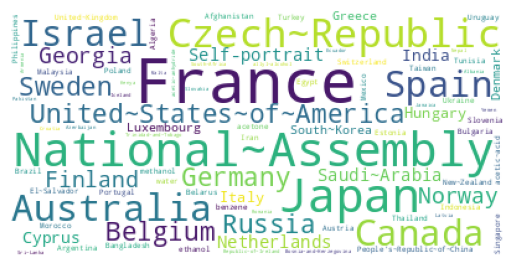

In [33]:
labels_list = [
    '~'.join(label.strip().split())
    for label in relevent_props_entity_df['ent_label']
]

wordcloud = WordCloud(max_font_size=50, stopwords=[],
                      background_color="white").generate_from_frequencies(
                          Counter(labels_list))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


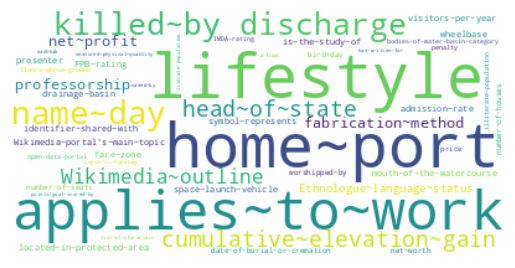

In [34]:
labels_list = [
    '~'.join(label.strip().split())
    for label in relevent_props_entity_df['prop_label']
]

wordcloud = WordCloud(max_font_size=50, stopwords=[],
                      background_color="white").generate_from_frequencies(
                          Counter(labels_list))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Choice TWO (no min number of entity per property) 

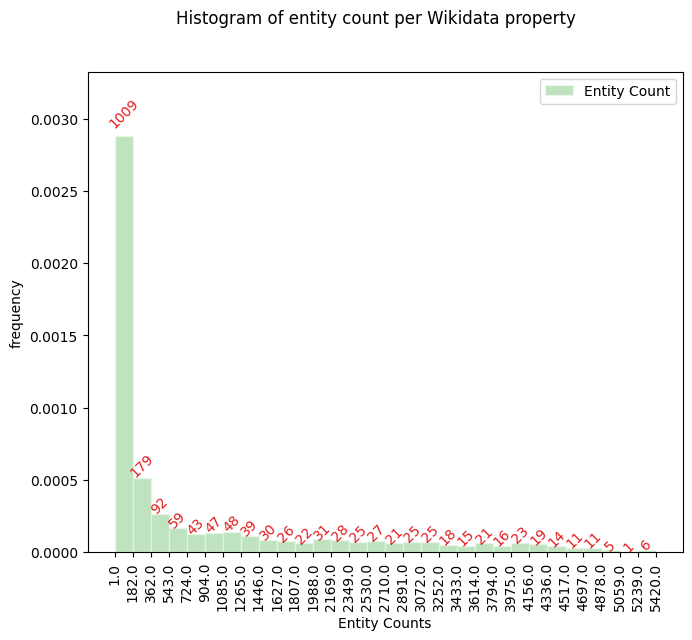

In [35]:
title = 'Histogram of entity count per Wikidata property'
label_x = 'Entity Counts'
label_y = 'frequency'
label_hist = ["Entity Count"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

bins = np.histogram_bin_edges(entities_count['entity_count'],
                              bins='auto').round()
_ = plot_hist([entities_count['entity_count'].to_numpy()],
              fig_data=fig_data,
              bins=[bins],
              count=True)

Relevent properties are those who have entities ~from 5~ upto 182

In [36]:
relevent_props_df = entities_count.copy()[
    entities_count['entity_count'] < bins[1]]
relevent_props_df['prop_label'] = relevent_props_df['property_id'].apply(
    get_prop_label)
display(relevent_props_df)

,property_id,entity,entity_count,prop_label
2,P1002,"[Q31170, Q61418, Q127110, Q172672, Q173384, Q2...",73,engine configuration
7,P1016,"[Q3030, Q11558, Q11560, Q107517, Q140489, Q149...",10,asteroid taxonomy
8,P1018,"[Q143, Q150, Q188, Q256, Q294, Q397, Q652, Q80...",144,language regulatory body
10,P10241,"[Q16521, Q24628, Q28270, Q49658, Q125027, Q147...",80,is an individual of taxon
13,P1028,"[Q9626, Q23361, Q32496, Q40599, Q145972, Q1780...",83,donated by
...,...,...,...,...
1918,P943,"[Q2377, Q5301, Q7397, Q12395, Q18940, Q35627, ...",90,programmer
1923,P967,"[Q71926, Q156013, Q216183, Q374368, Q514888, Q...",45,guest of honor
1926,P970,"[Q43054, Q147298, Q505544, Q748049, Q864951]",5,neurological function
1929,P9729,"[Q3544030, Q5645418]",2,replacement value


### Entity Distribution

In [37]:
entities_ar_counter = Counter(
    relevent_props_df.explode('entity')['entity']).most_common()
entities_ar_count = np.array([count for _, count in entities_ar_counter])
print(f'Number of unique entities: {len(entities_ar_count)}')
print(f'Min count: {entities_ar_count.min()}')
print(f'Max count: {entities_ar_count.max()}')
print(f'Average Count: {entities_ar_count.mean().round(2)}')
print(f'Median Count: {np.median(entities_ar_count).round(2)}')
print(f'Labels that are repeated {np.percentile(entities_ar_count, 25)} time represent 25% of labels')
print(f'Labels that are repeated less than or equal to {np.percentile(entities_ar_count, 75)} times represent 75% of labels')
print(f'Labels that are repeated less than or equal to {np.percentile(entities_ar_count, 90)} times represent 90% of labels')


Number of unique entities: 30151
Min count: 1
Max count: 22
Average Count: 1.42
Median Count: 1.0
Labels that are repeated 1.0 time represent 25% of labels
Labels that are repeated less than or equal to 1.0 times represent 75% of labels
Labels that are repeated less than or equal to 2.0 times represent 90% of labels


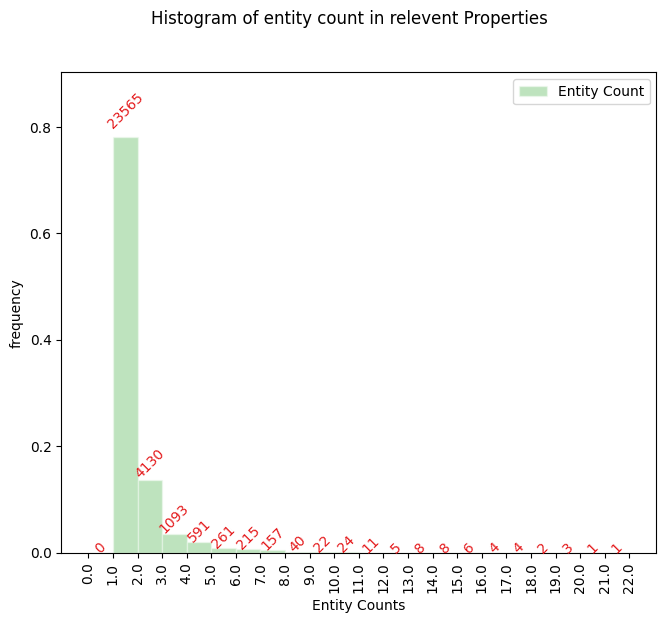

In [38]:
title = 'Histogram of entity count in relevent Properties'
label_x = 'Entity Counts'
label_y = 'frequency'
label_hist = ["Entity Count"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

_ = plot_hist([entities_ar_count],
              fig_data=fig_data,
              bins=[list(range(entities_ar_count.max() + 1))],
              count=True)


### Entities per Property Distribution

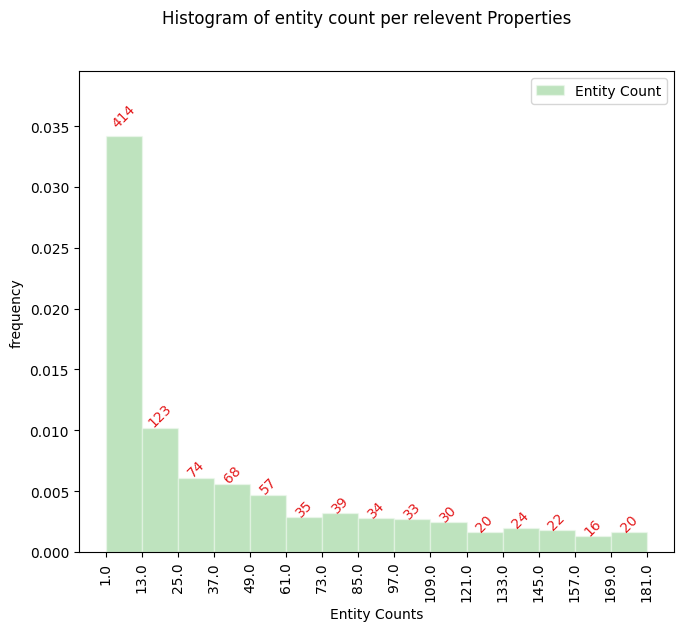

In [39]:
title = 'Histogram of entity count per relevent Properties'
label_x = 'Entity Counts'
label_y = 'frequency'
label_hist = ["Entity Count"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

bins = np.histogram_bin_edges(relevent_props_df['entity_count'],
                              bins='auto').round()
_ = plot_hist([relevent_props_df['entity_count']],
              fig_data=fig_data,
              bins=[bins],
              count=True)


In [40]:
relevent_props_df[relevent_props_df['entity_count'] >= 169][[
    'property_id', 'prop_label'
]]


,property_id,prop_label
84,P1125,Gini coefficient
161,P1336,territory claimed by
255,P1547,depends on software
277,P1595,charge
451,P209,highest judicial authority
481,P2134,total reserves
654,P2527,earthquake magnitude on the moment magnitude s...
891,P3189,innervated by
1021,P3818,KMRB film rating
1385,P5514,accredited by


### Labels Visualization

In [41]:
relevent_props_entity_df = relevent_props_df.explode('entity')
relevent_props_entity_df['ent_label'] = relevent_props_entity_df[
    'entity'].apply(entity_label)


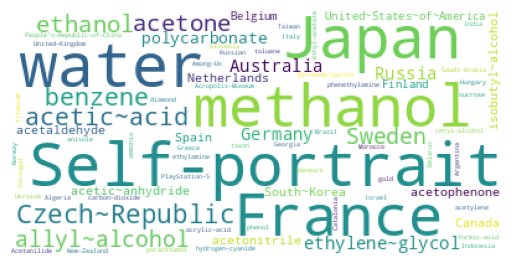

In [42]:
labels_list = [
    '~'.join(label.strip().split())
    for label in relevent_props_entity_df['ent_label']
]

wordcloud = WordCloud(max_font_size=50, stopwords=[],
                      background_color="white").generate_from_frequencies(
                          Counter(labels_list))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


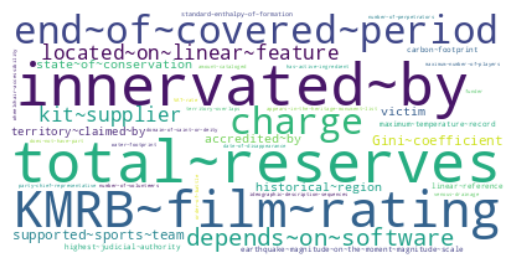

In [43]:
labels_list = [
    '~'.join(label.strip().split())
    for label in relevent_props_entity_df['prop_label']
]

wordcloud = WordCloud(max_font_size=50, stopwords=[],
                      background_color="white").generate_from_frequencies(
                          Counter(labels_list))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Labels Visualisation for all Entities

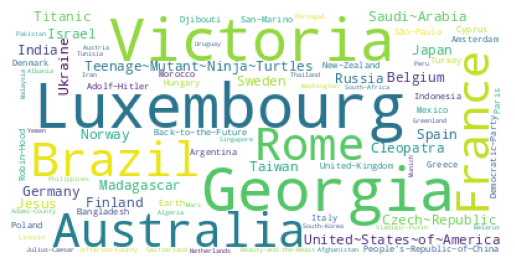

In [44]:
labels_list = [
    '~'.join(label.strip().split()) for label in prop_entity_ar_df['ent_label']
]

wordcloud = WordCloud(max_font_size=50, stopwords=[],
                      background_color="white").generate_from_frequencies(
                          Counter(labels_list))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


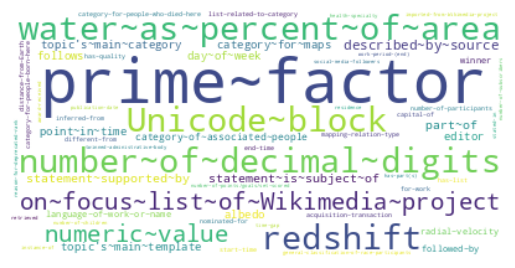

In [45]:
labels_list = [
    '~'.join(label.split()) for label in prop_entity_ar_df['prop_label']
]

wordcloud = WordCloud(max_font_size=50, stopwords=[],
                      background_color="white").generate_from_frequencies(
                          Counter(labels_list))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()